# Differential Capacity Hysteresis State model

In [1]:
%pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import pybamm

Note: you may need to restart the kernel to use updated packages.


## Model Equations

Herein the model equations for the Differential Capacity Hysteresis State open-circuit potential model are outlined, as described in Wycisk (2022).

### Hysteresis State Variable

This approach utilizes a state variable to represent the degree of hysteresis at a given time and stoichiometry, $h(z,t)$. The hysteresis is treated separately from the open-circuit potential, where the potential of the electrode is written as

$$ U = U_{avg}^0(z) + H(z) \cdot h(z,t) - \eta $$

Where $H(z)$ is a function representing the hysteresis as a function of stoichiometry, $z$, and where $\eta$ represents the sum of the overpotentials. $U_{avg}^0(z)$ is simply the average of the delithiation and lithiation open-circuit potential branches. $H(z)$ can be determined by finding the half-difference value between the lithiation and delithiation branches across the entire stoichiometry range. The state variable $h(z,t)$ is both stoichiometry and time-dependant, and spans between the range of -1 and 1. The hysteresis state variable $h(z,t)$ can be expressed in differential form with respect to time as

$$ \frac{dh(z,t)}{dt} = \left(\frac{k(z) \cdot I(t)}{Q_{cell}}\right)\left(1-\text{sgn}\left(\frac{dz(t)}{dt}\right) h(z,t)\right) $$

where $ k(z) $ is expressed as 

$$ k(z) = K \cdot \frac{1}{\left(C_{diff}\left(z\right)\right)^{x}} $$

And where $C_{diff}(z)$ is the differential capacity with respect to potential, expressed as 

$$ C_{diff}(z) = \frac{dQ}{dU_{avg}^0(z)} $$

Here, $Q$ is the capacity of the phase or active material experiencing the voltage hysteresis. The remaining parameters are $K$ and $x$ which are both fitting parameters that affect the response of the hysteresis state decay when passing charge in either direction.




## Comparing the DCHS and Current-Sigmoid model approaches

The behavior of the DCHS model is different than the current-sigmoid model approach for open-circuit potential in systems with hysteresis. Where the current-sigmoid model switches between hysteresis states simply based on the instantaneous current, the DCHS model switches based on the amount of charge passed through the active material phase while also relying on the previous hysteresis state. To assess this differentiated performance, we will compare it to the current-sigmoid model by adapting the Chen2020_composite parameter set.

First we generate the model, and specify the open-circuit potential methods for the negative and positive electrodes. To maintain consistency with the parameter set, two phases for the negative electrode will be defined.

In [2]:
model_DCHS = pybamm.lithium_ion.DFN(
    {
        "open-circuit potential": (("single", "Wycisk"), "single"),
        "particle phases": ("2", "1"),
    }
)

model_current_sigmoid = pybamm.lithium_ion.DFN(
    {
        "open-circuit potential": (("single", "current sigmoid"), "single"),
        "particle phases": ("2", "1"),
    }
)

Next, lets define the modifications to the parameter set

In [3]:
parameters_DCHS = pybamm.ParameterValues("Chen2020_composite")
parameters_current_sigmoid = pybamm.ParameterValues("Chen2020_composite")


# get the lithiation and delithiation functions
lithiation_ocp = parameters_DCHS["Secondary: Negative electrode lithiation OCP [V]"]
delithiation_ocp = parameters_DCHS["Secondary: Negative electrode delithiation OCP [V]"]


# define an additional OCP function
def ocp_avg(sto):
    return (lithiation_ocp(sto) + delithiation_ocp(sto)) / 2


# add additional parameters
parameters_DCHS.update(
    {
        "Secondary: Negative electrode OCP [V]": ocp_avg,
    },
    check_already_exists=False,
)

Next, we need to add the additional parameters required by the model

In [5]:
parameters_DCHS.update(
    {
        "Secondary: Negative particle hysteresis decay rate": 0.005,
        "Secondary: Negative particle hysteresis switching factor": 10,
        "Secondary: Initial hysteresis state in negative electrode": 0,
    },
    check_already_exists=False,
)


experiment = pybamm.Experiment(
    [
        ("Discharge at 1 C for 1 hour or until 2.5 V", "Rest for 15 minutes"),
        (
            "Charge at 1C until 4.2 V",
            "Hold at 4.2 V until 0.05 C",
            "Rest for 15 minutes",
        ),
    ]
)


simulation_dchs = pybamm.Simulation(
    model_DCHS, experiment=experiment, parameter_values=parameters_DCHS
)
solution_dchs = simulation_dchs.solve(calc_esoh=False)

simulation_current_sigmoid = pybamm.Simulation(
    model_current_sigmoid,
    experiment=experiment,
    parameter_values=parameters_current_sigmoid,
)

solution_current_sigmoid = simulation_current_sigmoid.solve(calc_esoh=False)

Now plotting the results and the hysteresis state 

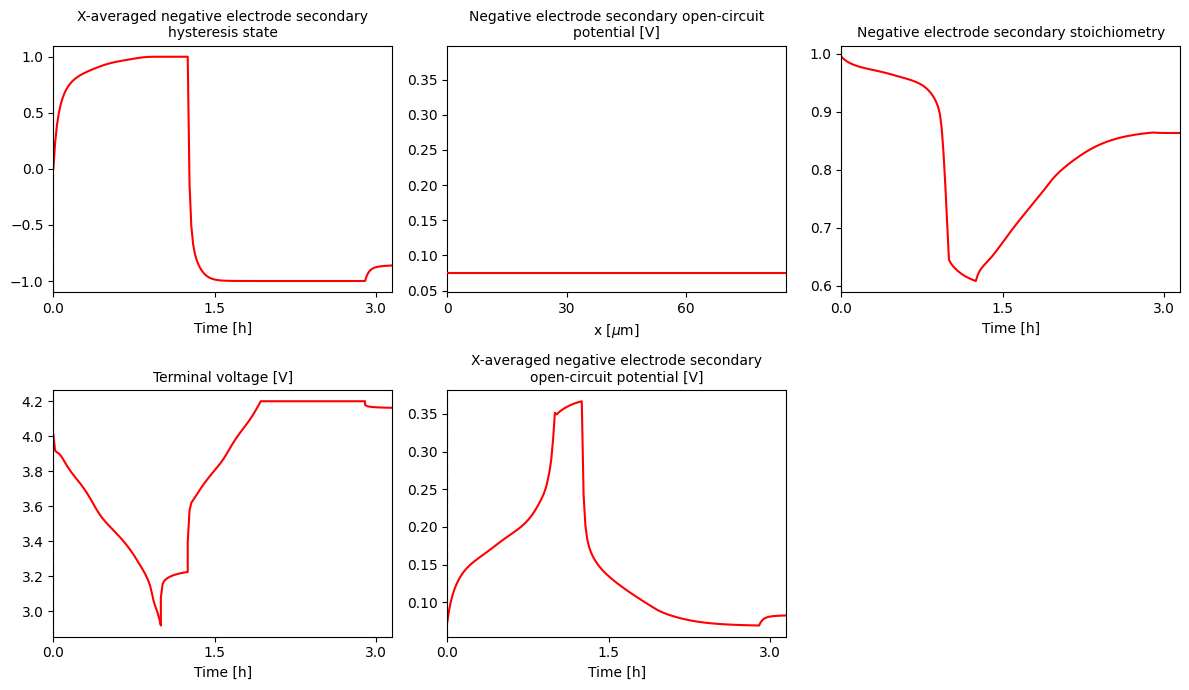

In [8]:
output_variables = [
    "X-averaged negative electrode secondary hysteresis state",
    "Negative electrode secondary open-circuit potential [V]",
    "Negative electrode secondary stoichiometry",
    "Terminal voltage [V]",
    "X-averaged negative electrode secondary open-circuit potential [V]",
]

pybamm.QuickPlot(solution_dchs, output_variables=output_variables).plot(0)

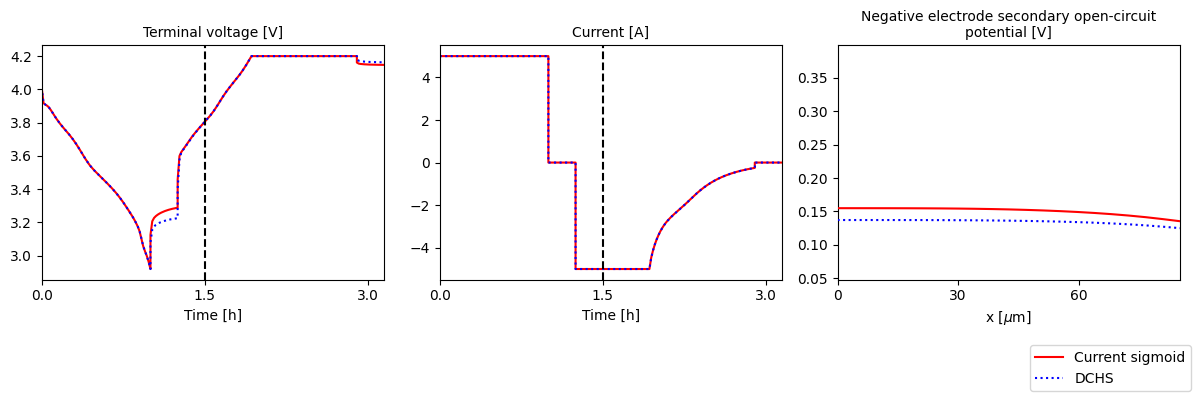

In [9]:
output_variables = [
    "Terminal voltage [V]",
    "Current [A]",
    "Negative electrode secondary open-circuit potential [V]",
]
pybamm.QuickPlot(
    [solution_current_sigmoid, solution_dchs],
    labels=["Current sigmoid", "DCHS"],
    output_variables=output_variables,
).plot(1.5)